<a href="https://colab.research.google.com/github/Preranakh/800LevelProject/blob/main/MNIST_clean_label_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!ssh-keygen -t rsa -b 4096

Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): 
Enter passphrase (empty for no passphrase): 
Enter same passphrase again: 
Your identification has been saved in /root/.ssh/id_rsa.
Your public key has been saved in /root/.ssh/id_rsa.pub.
The key fingerprint is:
SHA256:U12dOK5kUxfq7DAEtahv8uieWA1mAMgexUhyou41GIg root@bd2dccdcf8ce
The key's randomart image is:
+---[RSA 4096]----+
|=.*o     ...  ooo|
|=B ..     o..=.o.|
|E..  .   ..o+.o  |
|..o   . ...+o.   |
| o o   =S oooo   |
|. . . o +. .+    |
| .     o +   .   |
|      o *        |
|     .o= .       |
+----[SHA256]-----+


In [6]:
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

# github.com:22 SSH-2.0-babeld-2aa8e17d


In [7]:
!cat /root/.ssh/id_rsa.pub

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQC8nt1Se6L32kse4hwyqBw6SspiXmKKTPPgNsmS/olHeSkhYCZU8NtBoUz1XufygrgGk5LsJbKuc82pir2kpn2JWgON6x+LcfiNFUp43chczH6wpN6aUUEZps57ePH7ITvI6aauWiFuXn1zUGpBtJ7ekTXL7CUuY0qt8q2ZzTKLor/U0MD890EVxuJ3ynzDKQh2R1zc+R6uIoc8DtXRF4Ja0E+Xc6DUEJOqbO+JTtmUz4nM5u+/QDF0oMSFx2vssa49lndOln/aoOJG2pFlp3nbvMZVQDfkdy36HU4BC3NS0nYhAoTH4222ioUJMdJQUlU4222y2BTJecArPAnZXrKr6uRRYXkLMpzxLi1whVV0nA+wWfWMRgRTGy74Ka7OlUBujlp32/JdHjVGumftc/Swm7lu4++JRokK1qO0wn+LQLfEZ/Lr3cSbSG4GryPBi4TUQHBVBCIzXo5u1BNvrBGrKz61vmYdZ4L+0wdhh3liW5fdqS6fJcZu+B877LCHJ7i08OkdxmVPTyGB7T3Z6qt0ifvL1aY0fjCpnQu7SNWXcOpxhE9YEuePURL0FxAaewAY0StjAYnFH36Cvtsoq60AputKopd57b5mw8Vvy42Jevd9D5mnKqHcct8A+60d7mgdREdmvGc4hniWt3dPTpSApja6v9hQtjT1aAaY+xt+3Q== root@bd2dccdcf8ce


In [8]:
!ssh -T git@github.com

Hi Preranakh! You've successfully authenticated, but GitHub does not provide shell access.


In [9]:
!git config --global user.email "khatiwadaprerana@gmail.com"

In [14]:
!git config --global user.name "Preranakh"

In [10]:
!git clone git@github.com:Preranakh/Advanced-Topics-in-Computer-Applications-Project.git


Cloning into 'Advanced-Topics-in-Computer-Applications-Project'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 119 (delta 12), reused 0 (delta 0), pack-reused 92
Receiving objects: 100% (119/119), 47.93 MiB | 5.91 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [11]:
%cp -r Advanced-Topics-in-Computer-Applications-Project/src .

In [12]:
%rm -rf Advanced-Topics-in-Computer-Applications-Project

In [13]:
!pip3 install adversarial-robustness-toolbox


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 24.6 MB/s 


In [14]:

from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')

from src.classifiers.kerasclassifier import KerasClassifier
from src.attacks.clean_label_backdoor import (
    PoisoningAttackBackdoor,
    PoisoningAttackCleanLabelBackdoor,
)
from src.attacks.utils import pattern_backdoor
from src.preprocessing.utils import load_mnist, preprocess, to_categorical
from src.defences.adversarial_trainer_madry_pgd import (
    AdversarialTrainerMadryPGD,
)

In [15]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 10000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]


In [16]:

# Poison training data
percent_poison = .33
x_train, y_train = preprocess(x_raw, y_raw)
x_train = np.expand_dims(x_train, axis=3)

x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_test = np.expand_dims(x_test, axis=3)


In [17]:
  
# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [18]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
def create_model():    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

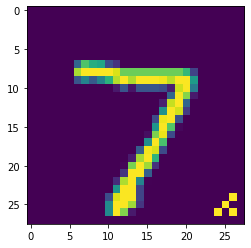

In [19]:
backdoor = PoisoningAttackBackdoor(pattern_backdoor)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
pdata, plabels = backdoor.poison(x_test, y=example_target)

plt.imshow(pdata[0].squeeze())

In [20]:
# Poison some percentage of all non-nines to nines
targets = to_categorical([9], 10)[0] 

proxy = AdversarialTrainerMadryPGD(KerasClassifier(create_model()), nb_epochs=10, eps=0.15, eps_step=0.001)
proxy.fit(x_train, y_train)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

src.classifiers.kerasclassifier.KerasClassifier(model=<keras.engine.sequential.Sequential object at 0x7fe6c3732550>, use_logits=False, channels_first=False, clip_values=None, preprocessing_defences=None, postprocessing_defences=None, preprocessing=<src.preprocessing.mean_std.StandardisationMeanStd object at 0x7fe6b29b9dd0>, input_layer=0, output_layer=0)
src.classifiers.kerasclassifier.KerasClassifier(model=<keras.engine.sequential.Sequential object at 0x7fe6c3732550>, use_logits=False, channels_first=False, clip_values=None, preprocessing_defences=None, postprocessing_defences=None, preprocessing=<src.preprocessing.mean_std.StandardisationMeanStd object at 0x7fe6b29b9dd0>, input_layer=0, output_layer=0)
src.classifiers.kerasclassifier.KerasClassifier(model=<keras.engine.sequential.Sequential object at 0x7fe6c3732550>, use_logits=False, channels_first=False, clip_values=None, preprocessing_defences=None, postprocessing_defences=None, preprocessing=<src.preprocessing.mean_std.Standardis

In [22]:
backdoor = PoisoningAttackBackdoor(pattern_backdoor)
attack = PoisoningAttackCleanLabelBackdoor(backdoor=backdoor, trained_classifier=proxy.get_classifier(),
                                           target=targets, pp_poison=percent_poison, norm=2, eps=5,
                                           eps_step=0.1, max_iter=200)
pdata, plabels = attack.poison(x_train, y_train)

src.classifiers.kerasclassifier.KerasClassifier(model=<keras.engine.sequential.Sequential object at 0x7fe6c3732550>, use_logits=False, channels_first=False, clip_values=None, preprocessing_defences=None, postprocessing_defences=None, preprocessing=<src.preprocessing.mean_std.StandardisationMeanStd object at 0x7fe6b29b9dd0>, input_layer=0, output_layer=0)


991


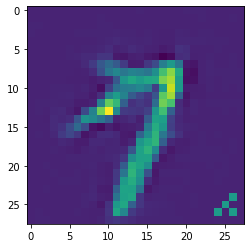

Index: 1 Label: 9


In [23]:
poisoned = pdata[np.all(plabels == targets, axis=1)]
poisoned_labels = plabels[np.all(plabels == targets, axis=1)]
print(len(poisoned))
for i in range(len(poisoned)):
    if poisoned[i][0][0] != 0:
        plt.imshow(poisoned[i].squeeze())
        plt.show()
        print(f"Index: {i} Label: {np.argmax(poisoned_labels[i])}")
        break

In [24]:
print(len(pdata))

10000


In [25]:
print(len(plabels))

10000


In [26]:
model = KerasClassifier(create_model())

In [27]:
model.fit(pdata, plabels, nb_epochs=10)

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 99us/sample - loss: 0.6756 - accuracy: 0.7863
Epoch 2/10
10000/10000 [==============================] - 1s 86us/sample - loss: 0.2239 - accuracy: 0.9333
Epoch 3/10
10000/10000 [==============================] - 1s 83us/sample - loss: 0.1444 - accuracy: 0.9565
Epoch 4/10
10000/10000 [==============================] - 1s 84us/sample - loss: 0.1165 - accuracy: 0.9644
Epoch 5/10
10000/10000 [==============================] - 1s 85us/sample - loss: 0.0880 - accuracy: 0.9726
Epoch 6/10
10000/10000 [==============================] - 1s 83us/sample - loss: 0.0787 - accuracy: 0.9737
Epoch 7/10
10000/10000 [==============================] - 1s 84us/sample - loss: 0.0596 - accuracy: 0.9812
Epoch 8/10
10000/10000 [==============================] - 1s 83us/sample - loss: 0.0493 - accuracy: 0.9838
Epoch 9/10
10000/10000 [==============================] - 1s 83us/sample - loss: 0.0449 - accuracy: 0.9853
Epoch 10/10
10


Poison test set accuracy (model): 0.34%


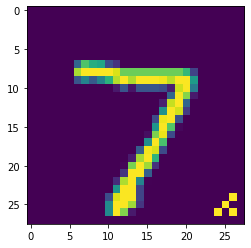

Prediction: 9


In [28]:
not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])

poison_preds = np.argmax(model.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (model): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))

In [31]:

warnings.filterwarnings('ignore')
from src.defences.adversarial_trainer import AdversarialTrainer

import numpy as np
import matplotlib.pyplot as plt
from src.attacks.projected_gradient_descent import ProjectedGradientDescent

In [32]:
from src.attacks.projected_gradient_descent import ProjectedGradientDescent

robust_classifier = KerasClassifier(create_model())
attacks = ProjectedGradientDescent(robust_classifier, eps=0.3, eps_step=0.01, max_iter=40)
trainer = AdversarialTrainer(robust_classifier, attacks, ratio=1.0)
trainer.fit(pdata, plabels, nb_epochs=8, batch_size=250)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

src.classifiers.kerasclassifier.KerasClassifier(model=<keras.engine.sequential.Sequential object at 0x7fe65c390090>, use_logits=False, channels_first=False, clip_values=None, preprocessing_defences=None, postprocessing_defences=None, preprocessing=<src.preprocessing.mean_std.StandardisationMeanStd object at 0x7fe65c3583d0>, input_layer=0, output_layer=0)
src.classifiers.kerasclassifier.KerasClassifier(model=<keras.engine.sequential.Sequential object at 0x7fe65c390090>, use_logits=False, channels_first=False, clip_values=None, preprocessing_defences=None, postprocessing_defences=None, preprocessing=<src.preprocessing.mean_std.StandardisationMeanStd object at 0x7fe65c3583d0>, input_layer=0, output_layer=0)
src.classifiers.kerasclassifier.KerasClassifier(model=<keras.engine.sequential.Sequential object at 0x7fe65c390090>, use_logits=False, channels_first=False, clip_values=None, preprocessing_defences=None, postprocessing_defences=None, preprocessing=<src.preprocessing.mean_std.Standardis

In [33]:
not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])
poison_preds = np.argmax(robust_classifier.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = py_test.shape[0]
print(y_test.shape[0])

10000


In [34]:
clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (model): %.2f%%" % (clean_acc * 100))



Poison test set accuracy (model): 81.55%


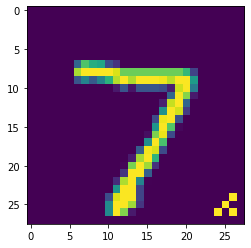

Prediction: 7


In [38]:
c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))

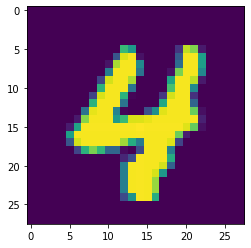

In [39]:
plt.imshow(pdata[0].squeeze())

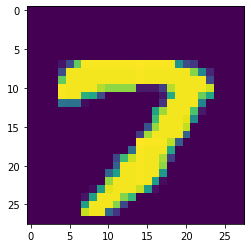

In [40]:
plt.imshow(pdata[2].squeeze())

In [41]:
poisoned = pdata[np.all(plabels == targets, axis=1)]

In [42]:
for i in range(len(pdata)):
  if plabels[i][9]==1:
    print(i)

7
8
10
11
40
44
66
68
73
79
89
93
94
120
121
130
131
140
149
154
173
193
205
218
223
234
241
247
252
264
268
269
274
299
303
323
325
333
340
359
361
364
367
379
383
432
435
468
470
486
498
499
510
513
514
522
523
529
541
543
550
577
588
597
603
604
617
626
644
646
650
651
664
689
695
703
708
732
739
749
750
763
787
794
803
824
852
855
862
882
887
894
904
915
920
930
938
945
946
950
981
999
1000
1011
1021
1044
1045
1046
1048
1053
1064
1069
1080
1089
1099
1128
1136
1143
1150
1152
1153
1169
1186
1193
1209
1219
1225
1246
1255
1256
1264
1265
1267
1268
1271
1278
1281
1282
1287
1290
1291
1306
1322
1325
1338
1343
1353
1367
1369
1399
1404
1416
1418
1432
1452
1460
1461
1477
1479
1484
1500
1511
1512
1542
1554
1560
1563
1571
1573
1584
1594
1598
1626
1637
1647
1661
1685
1692
1693
1695
1712
1732
1735
1748
1759
1783
1795
1802
1803
1821
1825
1840
1842
1850
1851
1890
1911
1913
1915
1923
1929
1932
1939
1940
1944
1956
1966
1969
1972
1974
2006
2007
2020
2057
2062
2069
2099
2107
2124
2133
2146
2156
2171
21